In [3]:
import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from IPython.display import display

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
num_classes     = 80
input_size      = 128
graph           = tf.Graph()

return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)

sess = tf.Session(graph=graph)
# with tf.Session(graph=graph) as sess:

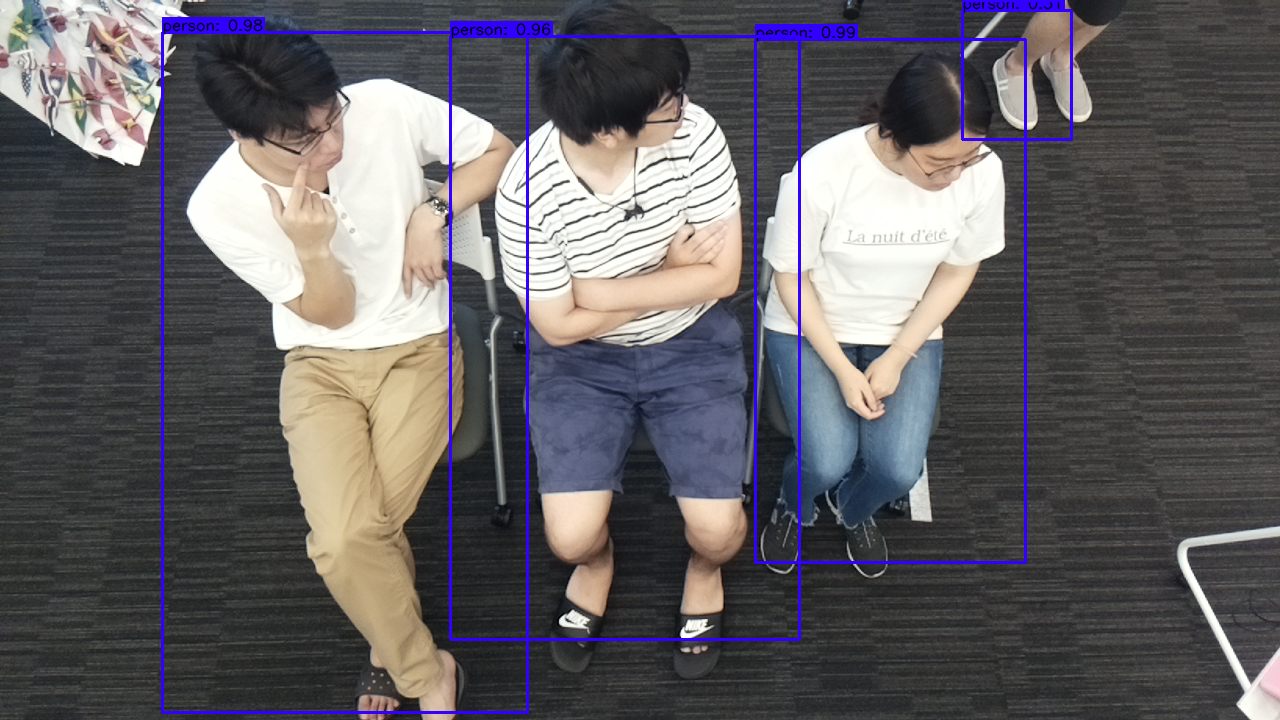

width: 0.2104, y1: 0.0542, x1: 0.5905, x2: 0.8009, y2: 0.7817, prob: 0.9851 앉은 사람
width: 0.2853, y1: 0.0450, x1: 0.1269, x2: 0.4122, y2: 0.9903, prob: 0.9842 앉은 사람
width: 0.2727, y1: 0.0501, x1: 0.3518, x2: 0.6246, y2: 0.8888, prob: 0.9573 앉은 사람
width: 0.0856, y1: 0.0152, x1: 0.7518, x2: 0.8373, y2: 0.1938, prob: 0.3094 오른쪽에 치우침 => 0.7518
People: 3


In [6]:
width = 1280
height = 720
image_path      = "./images/test1564107222.9107726.jpg"
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]
image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
image_data = image_data[np.newaxis, ...]
pred_sbbox, pred_mbbox, pred_lbbox = sess.run([return_tensors[1], return_tensors[2], return_tensors[3]],feed_dict={ return_tensors[0]: image_data})

pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_mbbox, (-1, 5 + num_classes)),
                            np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)

bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.3)
bboxes = utils.nms(bboxes, 0.4, method='nms')
image = utils.draw_bbox(original_image, bboxes)
image = Image.fromarray(image)
# image.show()
display(image)
num_people = 0
for box in bboxes:
    if box[5] == 0.0:
        print("width: {0:0.4f}, y1: {1:0.4f}, x1: {2:0.4f}, x2: {3:0.4f}, y2: {4:0.4f}, prob: {5:0.4f}".format((box[2]-box[0])/width,box[1]/height,box[0]/width, box[2]/width, box[3]/height, box[4]),end=" ")
        if box[2]-box[0] > width*0.3: # 넓이가 0.3 초과하면 standing
            print("넓이 초과 => {0:0.4f}".format((box[2]-box[0])/width))
            continue
        elif box[1] > height*0.5: # 위쪽 경계가 0.5 보다 아래에 있으면 standing
            print("아래에 치우침 => {0:0.4f}".format(box[1]/height))
            continue
        elif box[0] > width*0.625: # 왼쪽 경계가 0.625 보다 오른쪽에 있으면 standing 
            print("오른쪽에 치우침 => {0:0.4f}".format(box[0]/width))
            continue
        elif box[2] < width*0.375: # 오른쪽 경계가 0.375 보다 왼쪽에 있으면 standing
            print("왼쪽에 치우침 => {0:0.4f}".format(box[2]/width))
            continue
        elif box[3] < height*0.5: # 아래쪽 경계가 0.5보다 위에 있으면 standing
            print("위쪽에 치우침 => {0:0.4f}".format(box[3]/height))
            continue
        else:
            print("앉은 사람")
            num_people += 1
print("People: {}".format(num_people))

In [13]:
for box in bboxes:
    print(box[1])

5.220407485961914
14.768301963806152
71.02665710449219


In [3]:
bboxes

[array([9.82175171e+02, 1.06565981e+01, 1.26644238e+03, 2.64613098e+02,
        8.86111200e-01, 0.00000000e+00])]

In [3]:
bboxes[0]

array([399.01287842, 219.5496521 , 574.82592773, 471.54928589,
         0.9978981 ,   0.        ])

In [4]:
bboxes[1]

array([402.72622681,  11.59717941, 526.85723877, 186.44424438,
         0.6120711 ,   0.        ])

In [1]:
# ai 서버, display 클라이언트
# server.py

import flask
from flask import request, make_response, jsonify
from PIL import Image
import time

import cv2
import numpy as np
import core.utils as utils
import tensorflow as tf
from PIL import Image
from IPython.display import display

import requests

num_seats = input("좌석 수 :")
num_seats = int(num_seats)
global empty_num_seats
empty_num_seats = num_seats

app = flask.Flask(__name__)

return_elements = ["input/input_data:0", "pred_sbbox/concat_2:0", "pred_mbbox/concat_2:0", "pred_lbbox/concat_2:0"]
pb_file         = "./yolov3_coco.pb"
image_path      = "./images/capture.jpg"
num_classes     = 80
input_size      = 128
graph           = tf.Graph()

# IP = "172.29.148.144"
# PORT = 8899

width = 1280
height = 720


@app.route('/api/calculateEmptySeats', methods=['POST'])
def match():
    image = request.files['file']
    if image:
        image_path = 'images/test{}.jpg'.format(time.time())
        with open(image_path, 'wb') as fw:
            fw.write(image.read())
            
            start = time.time()
            original_image = cv2.imread(image_path)
            original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
            original_image_size = original_image.shape[:2]
            image_data = utils.image_preporcess(np.copy(original_image), [input_size, input_size])
            image_data = image_data[np.newaxis, ...]
            
            pred_sbbox, pred_mbbox, pred_lbbox = sess.run([return_tensors[1], return_tensors[2], return_tensors[3]],feed_dict={ return_tensors[0]: image_data})
            pred_bbox = np.concatenate([np.reshape(pred_sbbox, (-1, 5 + num_classes)),np.reshape(pred_mbbox, (-1, 5 + num_classes)),np.reshape(pred_lbbox, (-1, 5 + num_classes))], axis=0)
            
            bboxes = utils.postprocess_boxes(pred_bbox, original_image_size, input_size, 0.1)
            bboxes = utils.nms(bboxes, 0.5, method='nms')
            image = utils.draw_bbox(original_image, bboxes)
            image = Image.fromarray(image)
            print("Number of total seats: {}".format(num_seats))
            
            num_people = 0
            for box in bboxes:
                if box[5] == 0.0:
                    print("width: {0:0.4f}, y1: {1:0.4f}, x1: {2:0.4f}, x2: {3:0.4f}, y2: {4:0.4f}, prob: {5:0.4f}".format((box[2]-box[0])/width,box[1]/height,box[0]/width, box[2]/width, box[3]/height, box[4]),end=" ")
                    if box[2]-box[0] > width*0.3: # 넓이가 0.3 초과하면 standing
                        print("넓이 초과 => {0:0.4f}".format((box[2]-box[0])/width))
                        continue
                    elif box[1] > height*0.5: # 위쪽 경계가 0.5 보다 아래에 있으면 standing
                        print("아래에 치우침 => {0:0.4f}".format(box[1]/height))
                        continue
                    elif box[0] > width*0.625: # 왼쪽 경계가 0.625 보다 오른쪽에 있으면 standing 
                        print("오른쪽에 치우침 => {0:0.4f}".format(box[0]/width))
                        continue
                    elif box[2] < width*0.375: # 오른쪽 경계가 0.375 보다 왼쪽에 있으면 standing
                        print("왼쪽에 치우침 => {0:0.4f}".format(box[2]/width))
                        continue
                    elif box[3] < height*0.5: # 아래쪽 경계가 0.5보다 위에 있으면 standing
                        print("위쪽에 치우침 => {0:0.4f}".format(box[3]/height))
                        continue
                    else:
                        print("앉은 사람")
                        num_people += 1
            
#             num_people = 0
#             for box in bboxes:
#                 if box[5] == 0.0:
#                     print("width: {}, y1: {}, x1: {}, x2: {}, y2: {}".format(box[2]-box[0],box[1],box[0], box[2], box[3]))
#                 if box[5] == 0.0 and box[2]-box[0] < 250.0 and box[1] < 200 and box[0] < 500 and box[2] > 250 and box[3] > 300:
#                     num_people += 1


            print("Number of people: {}".format(num_people))
            global empty_num_seats
            empty_num_seats = num_seats-num_people
            if empty_num_seats < 0:
                empty_num_seats = 0
            print("Number of empty seats: {}".format(empty_num_seats))
#             requests.post(url="http://{}:{}/api/displayEmptySeats".format(IP,PORT), data={"num_empty_seats": num_seats})
            
            image.show()
            # display(image)
            end = time.time()
            print("{}seconds".format(end-start))
    else:
        print('Image empty!')
    return 'OK'

@app.route("/api/displayEmptySeats", methods=["POST"])
def display():
    global empty_num_seats
    
#     if empty_num_seats < 9:
#         empty_num_seats += 1
#     else:
#         empty_num_seats = 0
    return make_response(jsonify({"num_empty_seats": empty_num_seats}))

return_tensors = utils.read_pb_return_tensors(graph, pb_file, return_elements)
with tf.Session(graph=graph) as sess:
    app.run('0.0.0.0', port=5001, threaded=True)


좌석 수 :3


W0727 09:59:35.367959 18556 deprecation.py:323] From E:\jhm\RaspberryPi\core\utils.py:122: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.
W0727 09:59:35.407254 18556 deprecation_wrapper.py:119] From E:\jhm\RaspberryPi\core\utils.py:123: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
41.79711985588074seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
4.588252067565918seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
3.485214948654175seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
2.9521660804748535seconds
Number of total seats: 3
width: 0.3913, y1: 0.0719, x1: 0.4795, x2: 0.8708, y2: 0.8378, prob: 0.6834 넓이 초과 => 0.3913
width: 0.1689, y1: 0.0000, x1: 0.0020, x2: 0.1710, y2: 0.8380, prob: 0.1937 왼쪽에 치우침 => 0.1710
Number of people: 0
Number of empty seats: 3
2.5302717685699463seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
2.5959203243255615seconds
Number of total seats: 3
Number of people: 0
Number of empty seats: 3
2.6565349102020264seconds
Number of t

3.1424310207366943seconds
Number of total seats: 3
width: 0.4531, y1: 0.0000, x1: 0.5433, x2: 0.9964, y2: 0.9986, prob: 0.8171 넓이 초과 => 0.4531
Number of people: 0
Number of empty seats: 3
2.640291690826416seconds
Number of total seats: 3
width: 0.4509, y1: 0.0000, x1: 0.5446, x2: 0.9956, y2: 0.9986, prob: 0.8517 넓이 초과 => 0.4509
Number of people: 0
Number of empty seats: 3
3.1227004528045654seconds
Number of total seats: 3
width: 0.4239, y1: 0.0425, x1: 0.5745, x2: 0.9984, y2: 0.8403, prob: 0.6376 넓이 초과 => 0.4239
width: 0.2573, y1: 0.0216, x1: 0.5390, x2: 0.7963, y2: 0.8025, prob: 0.2177 앉은 사람
width: 0.2115, y1: 0.0000, x1: 0.5607, x2: 0.7721, y2: 0.4273, prob: 0.1268 위쪽에 치우침 => 0.4273
Number of people: 1
Number of empty seats: 2
3.2204768657684326seconds
Number of total seats: 3
width: 0.4223, y1: 0.0119, x1: 0.5649, x2: 0.9872, y2: 0.8182, prob: 0.8437 넓이 초과 => 0.4223
width: 0.2675, y1: 0.0300, x1: 0.5262, x2: 0.7938, y2: 0.8135, prob: 0.1965 앉은 사람
Number of people: 1
Number of empty 

In [7]:
# # display 서버

# import flask
# from flask import request, make_response, jsonify
# import time

# app = flask.Flask(__name__)

# @app.route("/api/displayEmptySeats", methods=["POST"])
# def match():
#     num_empty_seats = int(request.values["num_empty_seats"])
#     print("빈 좌석 수: {}".format(num_empty_seats))
    
#     return make_response(jsonify({"num_empty_seats": 4}))

# app.run("0.0.0.0", port=8899, threaded=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


In [59]:
# 빈 좌석 수 요청
# response.py


import requests

IP = "172.29.148.137"
PORT = 5001

res = requests.post(url="http://{}:{}/api/displayEmptySeats".format(IP,PORT))
res = res.text
res = res.split(':')[1]
res = res.split('}')[0]
res = int(res)
print(res)

4


In [ ]:
# 카메라로 찍은 사진 server에 전달
# client.py

from picamera import PiCamera
import time
from PIL import Image
import socket
import base64
import requests
from io import BytesIO

IP = '172.29.148.137'
PORT = 5001
#IMAGE_SIZE = (1920, 1080)
#IMAGE_SIZE = (1366, 768)
#time.sleep(5)

#with PiCamera(resolution=IMAGE_SIZE) as camera:
with PiCamera() as camera:
        stream = BytesIO()
        for i in camera.capture_continuous(stream, format='jpeg', use_video_port = True):
                stream.truncate()
                stream.seek(0)
                barray = stream.read(stream.getbuffer().nbytes)
                requests.post('http://{}:{}/api/calculateEmptySeats'.format(IP, PORT), files={'file': barray})
                time.sleep(10)
                stream.seek(0)